In [1]:
import scipy as sp
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import sklearn.metrics

In [314]:
np.isnan(np.random.randn(3)).any()
np.isinf(np.random.randn(3)).any()

False

In [328]:
get_num_par('mmf4')

4

In [353]:
rep0 = 5       
def get_num_par(model_id):
    if model_id in ['pow2','log2','exp2','lin2','ilog2']:
        return 2
    if model_id in ['pow3','exp3','vap3','expp3','expd3','logpower3']:
        return 3
    if model_id in ['mmf4','wbl4','exp4','pow4']:
        return 4

def fit_model(sizes, scores, sizes_extrapolation, model_id):
    def get_fun(beta):
        num_par = get_num_par(model_id)
        fun = None
        if num_par == 2:
            a, b = tuple(beta.astype(float))
        if num_par == 3:
            a, b, c = tuple(beta.astype(float))
        if num_par == 4:
            a, b, c, d = tuple(beta.astype(float))
        if model_id == 'pow2':
            fun = lambda x: -a * x **(-b)
        if model_id == 'pow3':
            fun = lambda x: a - b * x **(-c)
        if model_id == 'log2':
            fun = lambda x: -a * np.log(x) + b
        if model_id == 'exp3':
            fun = lambda x: a * np.exp(-b*x) + c
        if model_id == 'exp2':
            fun = lambda x: a * np.exp(-b*x)
        if model_id == 'lin2':
            fun = lambda x: a * x + b
        if model_id == 'vap3':
            fun = lambda x: np.exp(a + b/x + c * np.log(x))
        if model_id == 'mmf4':
            fun = lambda x: (a * b + c * x ** d)/(b + x ** d)
        if model_id == 'wbl4':
            fun = lambda x: (c - b * np.exp(-a*(x**d)))
        if model_id == 'exp4':
            fun = lambda x: c - np.exp(-a*(x**d) + b)
        if model_id == 'expp3':
            fun = lambda x: c - np.exp((x-b)**a)
        if model_id == 'pow4':
            fun = lambda x: c - (-a*x + b)**d
        if model_id == 'ilog2':
            fun = lambda x: b - (a/np.log(x))
        if model_id == 'expd3':
            fun = lambda x: c - (c - a)*np.exp(-b*x)
        if model_id == 'logpower3':
            fun = lambda x: a / (1 + (x / np.exp(b))**c)
        return fun
    
    def objective(beta):
        fun = get_fun(beta)
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((fun(size) - scores[i])**2)
        return np.array(penalty)
    
    beta_list = []
    trn_error = []
    
    rep = rep0
    i = 0
    while i < rep:
        num_par = get_num_par(model_id)
        print('parameters %d' % num_par)
        
        beta = None
        if num_par == 2:
            print('opt2')
            a, b = tuple(sp.optimize.least_squares(objective, np.random.rand(num_par), method="lm").x)
            beta = np.array([a, b])
        if num_par == 3:
            print('opt3')
            a, b, c = tuple(sp.optimize.least_squares(objective, np.random.rand(num_par), method="lm").x)
            beta = np.array([a, b, c])
        if num_par == 4:
            print('opt4')
            a, b, c, d = tuple(sp.optimize.least_squares(objective, np.random.rand(num_par), method="lm").x)
            beta = np.array([a, b, c, d])
        
        fun = get_fun(beta)
        extrapolations = fun(sizes_extrapolation)
        nan_error = np.isnan(extrapolations).any()
        inf_error = np.isinf(extrapolations).any()
        
        if nan_error or inf_error:
            pass # redo's the optimization since extrapolations failed
        else:       
            i += 1
            pass # save the parameter values and objective function
            beta_list.append(beta)
            trn_error.append(objective(beta))
            
    # select the best one that also manages to extrapolate
    trn_error = np.mean(np.array(trn_error))
    best_i = np.argmin(trn_error)
    print(trn_error)
    print(best_i)
    best_beta = beta_list[best_i]
    print(best_beta)
    return best_beta, get_fun(best_beta)

print('hallo')
X = np.array([0, 1, 2, 3, 4, 5])
X_extra = np.array([5, 7])
Y = np.array([0, 50, 30, 40, 50, 60])
fit_model(X, Y, X_extra, 'mmf4')
    


hallo
parameters 4
opt4
parameters 4
opt4
parameters 4
opt4
parameters 4
opt4
parameters 4
opt4
249.34385731096344
0
[  25.93326178 -257.22933949   45.21865599    6.28289329]


C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in power
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in power


(array([  25.93326178, -257.22933949,   45.21865599,    6.28289329]),
 <function __main__.fit_model.<locals>.get_fun.<locals>.<lambda>(x)>)

In [2]:

def get_ipl(sizes, scores):
    def ipl(beta):
        a, b, c = tuple(beta.astype(float))
        pl = lambda x: a - b * x **(-c)
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((pl(size) - scores[i])**2)
        return np.array(penalty)

    a, b, c = tuple(sp.optimize.least_squares(ipl, np.array([1,1,1]), method="lm").x)
    return (a, b, c), lambda x: a - b * x **(-c)

def get_ipl_no_bias(sizes, scores):
    def ipl_no_bias(beta):
        b, c = tuple(beta.astype(float))
        pl = lambda x: b * x **(-c)
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((pl(size) - scores[i])**2)
        return np.array(penalty)

    b, c = tuple(sp.optimize.least_squares(ipl_no_bias, np.array([1,1]), method="lm").x)
    return (b, c), lambda x: b * x **(-c)

def get_log2(sizes, scores):
    def log2(beta):
        a, c = tuple(beta.astype(float))
        pl = lambda x: -a * np.log(x) + c
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((pl(size) - scores[i])**2)
        return np.array(penalty)

    a, c = tuple(sp.optimize.least_squares(log2, np.array([1,1]), method="lm").x)
    return (a, c), lambda x: -a * np.log(x) + c

def get_exp3(sizes, scores):
    def exp3(beta):
        a, b, c = tuple(beta.astype(float))
        pl = lambda x: a * np.exp(-b*x) + c
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((pl(size) - scores[i])**2)
        return np.array(penalty)

    a, b, c = tuple(sp.optimize.least_squares(exp3, np.array([1,1,1]), method="lm").x)
    return (a, b, c), lambda x: a * np.exp(-b*x) + c

#c = 0.89
#a = -0.1
#b = 0.01
def get_exp3_good_init(sizes, scores):
    def exp3(beta):
        a, b, c = tuple(beta.astype(float))
        pl = lambda x: a * np.exp(-b*x) + c
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((pl(size) - scores[i])**2)
        return np.array(penalty)

    a, b, c = tuple(sp.optimize.least_squares(exp3, np.array([-0.1,0.01,0.9]), method="lm").x)
    return (a, b, c), lambda x: a * np.exp(-b*x) + c

def get_exp2(sizes, scores):
    def exp2(beta):
        a, b = tuple(beta.astype(float))
        pl = lambda x: a * np.exp(-b*x)
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((pl(size) - scores[i])**2)
        return np.array(penalty)

    a, b = tuple(sp.optimize.least_squares(exp2, np.array([1,1]), method="lm").x)
    return (a, b), lambda x: a * np.exp(-b*x)

def get_exp2_good_init(sizes, scores):
    def exp2(beta):
        a, b = tuple(beta.astype(float))
        pl = lambda x: a * np.exp(-b*x)
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((pl(size) - scores[i])**2)
        return np.array(penalty)

    a, b = tuple(sp.optimize.least_squares(exp2, np.array([-0.1,0.01]), method="lm").x)
    return (a, b), lambda x: a * np.exp(-b*x)

def get_lin2(sizes, scores):
    def lin2(beta):
        a, b = tuple(beta.astype(float))
        pl = lambda x: a * x + b
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((pl(size) - scores[i])**2)
        return np.array(penalty)

    a, b = tuple(sp.optimize.least_squares(lin2, np.array([1,1]), method="lm").x)
    return (a, b), lambda x: a*x + b

def get_constant(sizes, scores):
    
    a = scores[-1]
    return a, lambda x: (a + x) - x

def get_vp(sizes, scores):
    def vp(beta):
        a, b, c = tuple(beta.astype(float))
        fun = lambda x: np.exp(a + b/x + c * np.log(x))
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((fun(size) - scores[i])**2)
        return np.array(penalty)

    a, b, c = tuple(sp.optimize.least_squares(vp, np.array([1,1,1]), method="lm").x)
    return (a, b, c), lambda x: np.exp(a + b/x + c * np.log(x))


def get_mmf(sizes, scores):
    def mmf(beta):
        a, b, c, d = tuple(beta.astype(float))
        fun = lambda x: (a * b + c * x ** d)/(b + x ** d)
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((fun(size) - scores[i])**2)
        return np.array(penalty)

    a, b, c, d = tuple(sp.optimize.least_squares(mmf, np.array([1,1,1,1]), method="lm").x)
    return (a, b, c, d), lambda x: (a * b + c * x ** d)/(b + x ** d)

def get_wbl4(sizes, scores):
    def wbl4(beta):
        a, b, c, d = tuple(beta.astype(float))
        fun = lambda x: (c - b * np.exp(-a*(x**d)))
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((fun(size) - scores[i])**2)
        return np.array(penalty)

    a, b, c, d = tuple(sp.optimize.least_squares(wbl4, np.array([1,1,1,1]), method="lm").x)
    return (a, b, c, d), lambda x: (c - b * np.exp(-a*(x**d)))

def get_exp4(sizes, scores):
    def exp4(beta):
        a, b, c, d = tuple(beta.astype(float))
        pl = lambda x: c - np.exp(-a*(x**d) + b)
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((pl(size) - scores[i])**2)
        return np.array(penalty)

    a, b, c, d = tuple(sp.optimize.least_squares(exp4, np.array([1,1,1,1]), method="lm").x)
    return (a, b, c, d), lambda x: c - np.exp(-a*(x**d) + b)

def get_expp3(sizes, scores):
    def expp3(beta):
        a, b, c = tuple(beta.astype(float))
        pl = lambda x: c - np.exp((x-b)**a)
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((pl(size) - scores[i])**2)
        return np.array(penalty)

    a, b, c = tuple(sp.optimize.least_squares(expp3, np.array([-0.1,0,2.5]), method="lm").x)
    return (a, b, c), lambda x: c - np.exp((x-b)**a)


def get_pow4(sizes, scores):
    def pow4(beta):
        a, b, c, d = tuple(beta.astype(float))
        pl = lambda x: c - (-a*x + b)**d
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((pl(size) - scores[i])**2)
        return np.array(penalty)

    a, b, c, d = tuple(sp.optimize.least_squares(pow4, np.array([0.0001,0.2,1,1]), method="lm").x)
    return (a, b, c, d), lambda x: c - (-a*x + b)**d


def get_ilog2(sizes, scores):
    def ilog2(beta):
        a, c = tuple(beta.astype(float))
        pl = lambda x: c - (a/np.log(x))
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((pl(size) - scores[i])**2)
        return np.array(penalty)

    a, c = tuple(sp.optimize.least_squares(ilog2, np.array([1,1]), method="lm").x)
    return (a, c), lambda x: c - (a/np.log(x))

def get_expd3(sizes, scores):
    def expd3(beta):
        a, b, c = tuple(beta.astype(float))
        pl = lambda x: c - (c - a)*np.exp(-b*x)
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((pl(size) - scores[i])**2)
        return np.array(penalty)

    a, b, c = tuple(sp.optimize.least_squares(expd3, np.array([1,1,1]), method="lm").x)
    return (a, b, c), lambda x: c - (c - a)*np.exp(-b*x)

def get_logpower(sizes, scores):
    def logpower(beta):
        a, b, c = tuple(beta.astype(float))
        fun = lambda x: a / (1 + (x / np.exp(b))**c)
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((fun(size) - scores[i])**2)
        return np.array(penalty)

    a, b, c = tuple(sp.optimize.least_squares(logpower, np.array([1,1,1]), method="lm").x)
    return (a, b, c), lambda x: a / (1 + (x / np.exp(b))**c)

In [3]:
def get_multiple_extrapolations_mean_curve(df):
    rows = []
    pbar = tqdm(total = len(pd.unique(df["openmlid"])) * len(pd.unique(df["learner"])) * len(model_names))
    for openmlid, df_dataset in tqdm(df.groupby("openmlid")):
        for learner, df_learner in df_dataset.groupby("learner"):
            sizes = None
            scores = []
            for (inner, outer), df_seeded in df_learner.groupby(["inner_seed", "outer_seed"]):
                sizes_seed, scores_seed = df_seeded["size_train"].values, df_seeded["score_valid"].values
                if sizes is None:
                    sizes = sizes_seed
                scores.append(scores_seed)
            scores = np.array(scores)
            if len(scores.shape) != 2:
                print(f"Skipping {learner}")
                continue
            mean_scores = np.mean(scores, axis=0)
            #sizes, scores = df_seeded["size_train"].values, df_seeded["score_valid"].values
            for i in range(0,len(model_names)):
                extrapolation_fun = popular_models[i]
                #print(model_names[i])
                for offset in range(4, len(sizes)):
                    beta, model = extrapolation_fun(sizes[:offset], mean_scores[:offset])
                    predictions = np.round(model(sizes), 4)
                    assert(len(predictions) == len(sizes))
                    rows.append([openmlid, learner, sizes[offset - 1], predictions, model_names[i], beta])
                pbar.update(1)
    pbar.close()
    return pd.DataFrame(rows, columns=["openmlid", "learner", "max_anchor_seen", "prediction", "curve_model", "beta"])

In [4]:

def get_anchors_and_scores_mean_curve(df):
    rows = []
    for openmlid, df_dataset in tqdm(df.groupby("openmlid")):
        for learner, df_learner in df_dataset.groupby("learner"):
            sizes = None
            scores = []
            for (inner, outer), df_seeded in df_learner.groupby(["inner_seed", "outer_seed"]):
                sizes_seed, scores_seed = df_seeded["size_train"].values, df_seeded["score_valid"].values
                if sizes is None:
                    sizes = sizes_seed
                scores.append(scores_seed)
            scores = np.array(scores)
            if len(scores.shape) != 2:
                print(f"Skipping {learner}")
                continue
            mean_scores = np.mean(scores, axis=0)
            rows.append([openmlid, learner, sizes, mean_scores])
    return pd.DataFrame(rows, columns=["openmlid", "learner", "anchor_prediction", "score"])

In [5]:

model_names    = ['pow3', 'pow2', 'log2', 'exp2', 'exp3', 'lin2', 'baseline_last_constant', 'vap3','mmf4','wbl4','exp4','ilog2','expd3','logpower3']
popular_models = [get_ipl, get_ipl_no_bias, get_log2, get_exp2_good_init, get_exp3_good_init, get_lin2, get_constant, get_vp,get_mmf,get_wbl4,get_exp4,get_ilog2,get_expd3,get_logpower]


#model_names    = ['pow3', 'pow2', 'log2', 'exp2', 'exp3', 'lin2', 'baseline_last_constant', 'vap3','mmf4','wbl4','exp4','expp3','pow4','ilog2','expd3','logpower3']
#popular_models = [get_ipl, get_ipl_no_bias, get_log2, get_exp2_good_init, get_exp3_good_init, get_lin2, get_constant, get_vp,get_mmf,get_wbl4,get_exp4,get_expp3,get_pow4,get_ilog2,get_expd3,get_logpower]
assert(len(model_names) == len(popular_models))

def get_multiple_extrapolations(df):
    rows = []
    pbar = tqdm(total = len(pd.unique(df["openmlid"])) * len(pd.unique(df["learner"])) * 25 * 5)
    for openmlid, df_dataset in df.groupby("openmlid"):
        for learner, df_learner in df_dataset.groupby("learner"):
            for (inner, outer), df_seeded in df_learner.groupby(["inner_seed", "outer_seed"]):
                sizes, scores = df_seeded["size_train"].values, df_seeded["score_valid"].values
                for i in range(0,len(model_names)):
                    extrapolation_fun = popular_models[i]
                    for offset in range(4, len(sizes)):
                        beta, model = extrapolation_fun(sizes[:offset], scores[:offset])
                        predictions = np.round(model(sizes), 4)
                        assert(len(predictions) == len(sizes))
                        rows.append([openmlid, learner, outer, inner, sizes[offset - 1], predictions, model_names[i], beta])
                pbar.update(1)
    pbar.close()
    return pd.DataFrame(rows, columns=["openmlid", "learner", "outer_seed", "inner_seed", "max_anchor_seen", "prediction", "curve_model", "beta"])

def get_anchors_and_scores(df):
    rows = []
    pbar = tqdm(total = len(pd.unique(df["openmlid"])) * len(pd.unique(df["learner"])) * 25 * 5)
    for openmlid, df_dataset in df.groupby("openmlid"):
        for learner, df_learner in df_dataset.groupby("learner"):
            for (inner, outer), df_seeded in df_learner.groupby(["inner_seed", "outer_seed"]):
                sizes, scores = df_seeded["size_train"].values, df_seeded["score_valid"].values
                rows.append([openmlid, learner, outer, inner, sizes, scores])
                pbar.update(1)
    pbar.close()
    return pd.DataFrame(rows, columns=["openmlid", "learner", "outer_seed", "inner_seed", "anchor_prediction", "score"])


In [125]:



def metrics_per_row(row, score, anchor_prediction):
    
    max_anchor_seen = row.max_anchor_seen
    prediction = row.prediction
    max_anchor = np.max(anchor_prediction)
    percentage_train = np.round(max_anchor_seen/max_anchor*100)/100

    trn_ind = np.argwhere(max_anchor_seen == anchor_prediction)[0][0] # recover offset
    trn_indices = range(0,(trn_ind+1))
    tst_indices = range(trn_ind+1,len(anchor_prediction))
    n_trn = len(trn_indices)
    
    y_trn_hat = prediction[trn_indices]
    y_trn = score[trn_indices]
    y_tst_hat = prediction[tst_indices]
    y_tst = score[tst_indices]

    MSE_trn = np.mean((y_trn - y_trn_hat)**2)
    MSE_tst = np.mean((y_tst - y_tst_hat)**2)
    MSE_tst_last = (y_tst[-1] -  y_tst_hat[-1])**2
    L1_trn = np.mean((y_trn -y_trn_hat)**2)
    L1_tst = np.mean((y_tst - y_tst_hat)**2)
    L1_tst_last = (y_tst[-1] - y_tst_hat[-1])**2
    
    return [MSE_trn,MSE_tst,MSE_tst_last,L1_trn,L1_tst,L1_tst_last,max_anchor_seen,percentage_train,n_trn,row.curve_model]

In [7]:
def get_info(df_info, openmlid, learner, outer_seed, inner_seed):
    q = df_info.query('openmlid==@openmlid and learner==@learner and outer_seed==@outer_seed and inner_seed == @inner_seed')
    q = q.iloc[0,:]
    return [q.anchor_prediction, q.score]

In [8]:
def get_info_mean_curve(df_info, openmlid, learner):
    q = df_info.query('openmlid==@openmlid and learner==@learner')
    q = q.iloc[0,:]
    return [q.anchor_prediction, q.score]

In [9]:
def df_compute_metrics_mean_curve(df,df_info):
    pbar = tqdm(total=len(df))
    rows_metrics = []
    for i in range(0,len(df)):
        row = df.iloc[i,:]
        anchor_prediction, score = get_info_mean_curve(df_info, row.openmlid, row.learner)
        rows_metrics.append(metrics_per_row(row,score,anchor_prediction))
        pbar.update(1)
    pbar.close()
    df_metrics = pd.DataFrame(rows_metrics,columns=['MSE trn','MSE tst','MSE tst last','L1 trn','L1 tst','L1 tst last','max anchor seen','percentage','n','curve_model'])
    return df_metrics

In [10]:
df = pd.read_csv("lcdb.csv")
df_small = df
print('computing extrapolations...')
df_extrapolations = get_multiple_extrapolations_mean_curve(df_small)
df_extrapolations.to_csv('extrapolations.csv')
print('computing anchors and scores...')
df_anchors_and_scores = get_anchors_and_scores_mean_curve(df_small)
df_anchors_and_scores.to_csv('anchors_scores.csv')

computing extrapolations...


  0%|          | 0/28000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:195: RuntimeWarning: overflow encountered in exp
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:198: RuntimeWarning: overflow encountered in double_scalars
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:195: RuntimeWarning: overflow encountered in double_scalars
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:133: RuntimeWarning: overflow encountered in power
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:140: RuntimeWarning: overflow encountered in power
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:136: RuntimeWarning: overflow encountered in double_scalars
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:133: RuntimeWarning: overflow encountered in exp
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ip

Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis


C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: overflow encountered in power
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in true_divide


Skipping SVC_linear
Skipping SVC_poly
Skipping SVC_rbf
Skipping SVC_sigmoid
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.ensemble.GradientBoostingClassifier
Skipping sklearn.linear_model.LogisticRegression
Skipping sklearn.linear_model.PassiveAggressiveClassifier
Skipping sklearn.linear_model.Perceptron
Skipping sklearn.linear_model.SGDClassifier
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis


C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: overflow encountered in exp


Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping SVC_linear
Skipping SVC_poly
Skipping SVC_rbf
Skipping SVC_sigmoid
Skipping sklearn.ensemble.GradientBoostingClassifier
Skipping sklearn.linear_model.LogisticRegression
Skipping sklearn.linear_model.PassiveAggressiveClassifier
Skipping sklearn.linear_model.Perceptron
Skipping sklearn.linear_model.SGDClassifier


C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:133: RuntimeWarning: overflow encountered in double_scalars
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:140: RuntimeWarning: overflow encountered in multiply
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:145: RuntimeWarning: overflow encountered in double_scalars
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:152: RuntimeWarning: overflow encountered in multiply


Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping SVC_linear
Skipping SVC_poly
Skipping SVC_rbf
Skipping SVC_sigmoid
Skipping sklearn.ensemble.GradientBoostingClassifier
Skipping sklearn.linear_model.LogisticRegression
Skipping sklearn.linear_model.PassiveAggressiveClassifier
Skipping sklearn.linear_model.Perceptron
Skipping sklearn.linear_model.SGDClassifier


C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\scipy\optimize\_numdiff.py:579: RuntimeWarning: overflow encountered in true_divide
  J_transposed[i] = df / dx


Skipping SVC_linear


C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:86: RuntimeWarning: overflow encountered in exp


Skipping sklearn.ensemble.GradientBoostingClassifier
Skipping sklearn.neural_network.MLPClassifier
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis


C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:207: RuntimeWarning: overflow encountered in true_divide
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:214: RuntimeWarning: overflow encountered in true_divide


Skipping SVC_poly
Skipping SVC_rbf
Skipping sklearn.ensemble.ExtraTreesClassifier
Skipping sklearn.ensemble.GradientBoostingClassifier


C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:207: RuntimeWarning: overflow encountered in exp
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:207: RuntimeWarning: divide by zero encountered in double_scalars


Skipping sklearn.neural_network.MLPClassifier


C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\numpy\core\fromnumeric.py:57: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)


Skipping sklearn.ensemble.ExtraTreesClassifier
Skipping sklearn.ensemble.GradientBoostingClassifier
Skipping sklearn.ensemble.RandomForestClassifier
Skipping sklearn.naive_bayes.MultinomialNB
Skipping sklearn.neighbors.KNeighborsClassifier
Skipping sklearn.neural_network.MLPClassifier
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.LinearDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.ensemble.GradientBoostingClassifier
Skipping SVC_poly
Skipping SVC_sigmoid
Skipping sklearn.neural_network.MLPClassifier
Skipping SVC_linear
Skipping SVC_poly
Skipping sklearn.ensemble.ExtraTreesClassifier
Skipping sklearn.ensemble.RandomForestClassifier


C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:121: RuntimeWarning: overflow encountered in power
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in double_scalars


Skipping sklearn.neighbors.KNeighborsClassifier
Skipping SVC_poly
Skipping SVC_rbf
Skipping sklearn.ensemble.GradientBoostingClassifier
Skipping sklearn.neighbors.KNeighborsClassifier
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping SVC_rbf
Skipping sklearn.discriminant_analysis.LinearDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.linear_model.LogisticRegression
Skipping sklearn.neural_network.MLPClassifier


C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in double_scalars
  import sys
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.


Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.ensemble.GradientBoostingClassifier
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.ensemble.GradientBoostingClassifier
Skipping SVC_rbf
Skipping SVC_sigmoid
Skipping sklearn.discriminant_analysis.LinearDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.neural_network.MLPClassifier
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping SVC_poly
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.ensemble.GradientBoostingClassifier
Skipping sklearn.discriminant_analysis.QuadraticDisc

  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if sys.path[0] == '':


Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping SVC_linear
Skipping SVC_poly
Skipping SVC_rbf
Skipping SVC_sigmoid
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.ensemble.GradientBoostingClassifier
Skipping sklearn.linear_model.LogisticRegression
Skipping sklearn.linear_model.PassiveAggressiveClassifier
Skipping sklearn.linear_model.Perceptron
Skipping sklearn.linear_model.SGDClassifier
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.QuadraticDiscrimina

# Check for bad predictions

In [120]:
rows_filtered = []
pbar = tqdm(total=len(df_extrapolations))
for i in range(0,len(df_extrapolations)):
    row = df_extrapolations.iloc[i,:]
    if not np.isnan(row.prediction).any():
        rows_filtered.append(row)
    pbar.update(1)
pbar.close()
df_extrapolations_filtered = pd.DataFrame(rows_filtered)

  0%|          | 0/301210 [00:00<?, ?it/s]

In [121]:
df_extrapolations_filtered

,openmlid,learner,max_anchor_seen,prediction,curve_model,beta
0,3,SVC_linear,45,"[0.6866, 0.7361, 0.7793, 0.8221, 0.8645, 0.905...",pow3,"(1.8259050363918465, 1.60011081278419, 0.12250..."
1,3,SVC_linear,64,"[0.6864, 0.7363, 0.7793, 0.8214, 0.8626, 0.901...",pow3,"(1.5915489561835012, 1.3955173506046286, 0.156..."
2,3,SVC_linear,91,"[0.6851, 0.7377, 0.7808, 0.8211, 0.8587, 0.892...",pow3,"(1.1986751382205407, 1.171780585157037, 0.2975..."
3,3,SVC_linear,128,"[0.6842, 0.7388, 0.7823, 0.822, 0.858, 0.8894,...",pow3,"(1.1121255708956674, 1.2130204193755982, 0.375..."
4,3,SVC_linear,181,"[0.6837, 0.7392, 0.783, 0.8224, 0.8577, 0.8881...",pow3,"(1.0833170977575124, 1.253142327625819, 0.4122..."
...,...,...,...,...,...,...
301205,910,sklearn.tree.ExtraTreeClassifier,128,"[0.5817, 0.5936, 0.6046, 0.6162, 0.6284, 0.640...",logpower3,"(47.80976090118021, 80.7970006134594, -0.05635..."
301206,910,sklearn.tree.ExtraTreeClassifier,181,"[0.5798, 0.5928, 0.6049, 0.6177, 0.6311, 0.644...",logpower3,"(66.19090693689249, 79.35081398593735, -0.0617..."
301207,910,sklearn.tree.ExtraTreeClassifier,256,"[0.5778, 0.5919, 0.605, 0.6188, 0.6334, 0.6483...",logpower3,"(89.90912658715132, 78.33504461893112, -0.0667..."
301208,910,sklearn.tree.ExtraTreeClassifier,362,"[0.5778, 0.5919, 0.605, 0.6188, 0.6334, 0.6484...",logpower3,"(102.62142096273733, 80.35794040149847, -0.066..."


In [59]:
def get_mmf(sizes, scores):
    def mmf(beta):
        a, b, c, d = tuple(beta.astype(float))
        fun = lambda x: (a * b + c * x ** d)/(b + x ** d)
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((fun(size) - scores[i])**2)
        return np.array(penalty)

    a, b, c, d = tuple(sp.optimize.least_squares(mmf, np.random.randn(4), method="lm").x)
    return (a, b, c, d), lambda x: (a * b + c * x ** d)/(b + x ** d)

In [80]:

beta
#row.beta

(0.10544640365826931,
 -22.0230325738433,
 289.02195628308147,
 -2.841127819730163)

In [81]:
row.beta

(5.835647370299569, 4.797391741935361, 0.10371701844843503, 102.48989084943263)

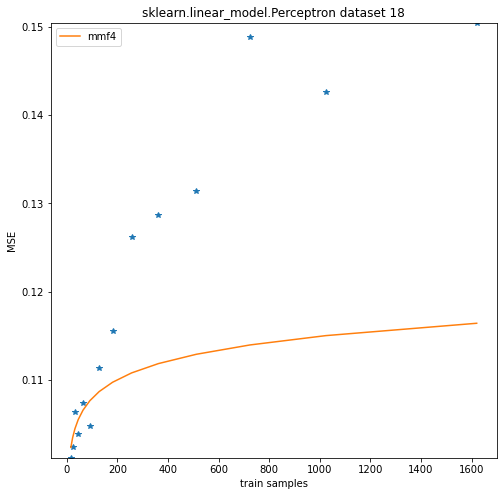

In [106]:
row_check = 0
row = rows[row_check]
learner = row.learner
openmlid = row.openmlid
n = 9
#df_selected = df_total_clean.query('openmlid==@openmlid and learner==@learner and n==@n')
#df_selected

[X, Y] = get_info_mean_curve(df_anchors_and_scores, openmlid, learner)

offset = np.argwhere(X == row.max_anchor_seen)[0][0]


X_trn = X[:offset+1]
Y_trn = Y[:offset+1]

get_fun = popular_models[model_names.index(row.curve_model)]

beta, predictor = get_mmf(X_trn,Y_trn)

plt.figure(figsize=(8,8))
plt.plot(X,Y,'*')
#for i in range(0,len(df_selected)):
#    row = df_selected.iloc[i,:]
Y_hat = predictor(X)
plt.plot(X,Y_hat,'-',label=row.curve_model)
    
plt.title('%s dataset %d' % (learner, openmlid))
plt.ylim([np.min(Y),np.max(Y)])
plt.xlabel('train samples')
plt.ylabel('MSE')
plt.legend()
plt.show()


In [18]:
X

array([  16,   23,   32,   45,   64,   91,  128,  181,  256,  362,  512,
        724, 1024, 1620], dtype=int64)

In [126]:
print('computing metrics....')
df_metrics = df_compute_metrics_mean_curve(df_extrapolations_filtered,df_anchors_and_scores)
df_metrics.to_csv('metrics.csv')

computing metrics....


  0%|          | 0/301203 [00:00<?, ?it/s]

C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in square
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in double_scalars
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in square
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in double_scalars
Exception ignored in: <function tqdm.__del__ at 0x000001D05EE93D38>
Traceback (most recent call last):
  File "C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\tqdm\std.py", line 1162, in __del__
    self.close()
  File "C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\tqdm\notebook.py", line 287, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


In [127]:
df_metrics

,MSE trn,MSE tst,MSE tst last,L1 trn,L1 tst,L1 tst last,max anchor seen,percentage,n,curve_model
0,0.000001,0.020309,0.060189,0.000001,0.020309,0.060189,45,0.02,4,pow3
1,0.000001,0.016770,0.045341,0.000001,0.016770,0.045341,64,0.02,5,pow3
2,0.000005,0.005540,0.013464,0.000005,0.005540,0.013464,91,0.04,6,pow3
3,0.000008,0.002852,0.006278,0.000008,0.002852,0.006278,128,0.05,7,pow3
4,0.000009,0.002108,0.004178,0.000009,0.002108,0.004178,181,0.07,8,pow3
...,...,...,...,...,...,...,...,...,...,...
301198,0.000052,0.000904,0.001640,0.000052,0.000904,0.001640,128,0.16,7,logpower3
301199,0.000067,0.000471,0.000729,0.000067,0.000471,0.000729,181,0.22,8,logpower3
301200,0.000082,0.000153,0.000216,0.000082,0.000153,0.000216,256,0.32,9,logpower3
301201,0.000075,0.000222,0.000213,0.000075,0.000222,0.000213,362,0.45,10,logpower3


# Cleaning the data and processing

In [128]:
print('some strange values:')
print(df_metrics.isin([np.nan, np.inf, -np.inf]).sum())
df_metrics_na = df_metrics.replace([np.inf, -np.inf], np.nan)


some strange values:
MSE trn              0
MSE tst            262
MSE tst last       262
L1 trn               0
L1 tst             262
L1 tst last        262
max anchor seen      0
percentage           0
n                    0
curve_model          0
dtype: int64


In [129]:
df_extrapolations_no_curve_model = df_extrapolations.loc[:, df_extrapolations.columns != 'curve_model']
df_total = pd.concat([df_extrapolations_no_curve_model,df_metrics_na],axis=1)
df_total

,openmlid,learner,max_anchor_seen,prediction,beta,MSE trn,MSE tst,MSE tst last,L1 trn,L1 tst,L1 tst last,max anchor seen,percentage,n,curve_model
0,3,SVC_linear,45,"[0.6866, 0.7361, 0.7793, 0.8221, 0.8645, 0.905...","(1.8259050363918465, 1.60011081278419, 0.12250...",0.000001,0.020309,0.060189,0.000001,0.020309,0.060189,45.0,0.02,4.0,pow3
1,3,SVC_linear,64,"[0.6864, 0.7363, 0.7793, 0.8214, 0.8626, 0.901...","(1.5915489561835012, 1.3955173506046286, 0.156...",0.000001,0.016770,0.045341,0.000001,0.016770,0.045341,64.0,0.02,5.0,pow3
2,3,SVC_linear,91,"[0.6851, 0.7377, 0.7808, 0.8211, 0.8587, 0.892...","(1.1986751382205407, 1.171780585157037, 0.2975...",0.000005,0.005540,0.013464,0.000005,0.005540,0.013464,91.0,0.04,6.0,pow3
3,3,SVC_linear,128,"[0.6842, 0.7388, 0.7823, 0.822, 0.858, 0.8894,...","(1.1121255708956674, 1.2130204193755982, 0.375...",0.000008,0.002852,0.006278,0.000008,0.002852,0.006278,128.0,0.05,7.0,pow3
4,3,SVC_linear,181,"[0.6837, 0.7392, 0.783, 0.8224, 0.8577, 0.8881...","(1.0833170977575124, 1.253142327625819, 0.4122...",0.000009,0.002108,0.004178,0.000009,0.002108,0.004178,181.0,0.07,8.0,pow3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301205,910,sklearn.tree.ExtraTreeClassifier,128,"[0.5817, 0.5936, 0.6046, 0.6162, 0.6284, 0.640...","(47.80976090118021, 80.7970006134594, -0.05635...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
301206,910,sklearn.tree.ExtraTreeClassifier,181,"[0.5798, 0.5928, 0.6049, 0.6177, 0.6311, 0.644...","(66.19090693689249, 79.35081398593735, -0.0617...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
301207,910,sklearn.tree.ExtraTreeClassifier,256,"[0.5778, 0.5919, 0.605, 0.6188, 0.6334, 0.6483...","(89.90912658715132, 78.33504461893112, -0.0667...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
301208,910,sklearn.tree.ExtraTreeClassifier,362,"[0.5778, 0.5919, 0.605, 0.6188, 0.6334, 0.6484...","(102.62142096273733, 80.35794040149847, -0.066...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [130]:
df_total.describe()

,openmlid,max_anchor_seen,MSE trn,MSE tst,MSE tst last,L1 trn,L1 tst,L1 tst last,max anchor seen,percentage,n
count,301210.000000,301210.000000,3.012030e+05,3.009410e+05,3.009410e+05,3.012030e+05,3.009410e+05,3.009410e+05,301203.000000,301203.000000,301203.000000
mean,479.066977,4407.676179,2.182149e-03,3.582782e+298,7.059158e+299,2.182149e-03,3.582782e+298,7.059158e+299,4407.733084,0.188983,10.544360
std,326.777097,26788.555624,1.859653e-02,inf,inf,1.859653e-02,inf,inf,26788.861099,0.216425,5.080584
min,3.000000,45.000000,2.311116e-33,0.000000e+00,0.000000e+00,2.311116e-33,0.000000e+00,0.000000e+00,45.000000,0.000000,4.000000
25%,180.000000,128.000000,1.885377e-05,1.761525e-04,2.003923e-04,1.885377e-05,1.761525e-04,2.003923e-04,128.000000,0.030000,7.000000
50%,399.000000,362.000000,7.446705e-05,1.360323e-03,2.273001e-03,7.446705e-05,1.360323e-03,2.273001e-03,362.000000,0.100000,10.000000
75%,807.000000,1024.000000,3.737903e-04,1.223753e-02,2.583863e-02,3.737903e-04,1.223753e-02,2.583863e-02,1024.000000,0.300000,13.000000
max,910.000000,524288.000000,7.623948e-01,4.578164e+303,8.240695e+304,7.623948e-01,4.578164e+303,8.240695e+304,524288.000000,0.990000,31.000000


In [131]:
df_total.isin([np.nan, np.inf, -np.inf]).sum()

openmlid             0
learner              0
max_anchor_seen      0
prediction           0
beta                 0
MSE trn              7
MSE tst            269
MSE tst last       269
L1 trn               7
L1 tst             269
L1 tst last        269
max anchor seen      7
percentage           7
n                    7
curve_model          7
dtype: int64

In [133]:
df_total_clean = df_total.dropna(axis=0)
df_total_clean.isin([np.nan, np.inf, -np.inf]).sum()

openmlid           0
learner            0
max_anchor_seen    0
prediction         0
beta               0
MSE trn            0
MSE tst            0
MSE tst last       0
L1 trn             0
L1 tst             0
L1 tst last        0
max anchor seen    0
percentage         0
n                  0
curve_model        0
dtype: int64

In [134]:
df_total_clean = df_total_clean.rename(columns={'MSE trn':'MSE_trn','MSE tst':'MSE_tst','MSE tst last': 'MSE_tst_last', 'L1 trn':'L1_trn', 'L1 tst':'L1_tst', 'L1 tst last':'L1_tst_last'})

In [135]:
df_total_clean.describe()

,openmlid,max_anchor_seen,MSE_trn,MSE_tst,MSE_tst_last,L1_trn,L1_tst,L1_tst_last,max anchor seen,percentage,n
count,300941.000000,300941.000000,3.009410e+05,3.009410e+05,3.009410e+05,3.009410e+05,3.009410e+05,3.009410e+05,300941.000000,300941.000000,300941.000000
mean,479.126450,4340.345058,2.183232e-03,3.582782e+298,7.059158e+299,2.183232e-03,3.582782e+298,7.059158e+299,4411.454162,0.189146,10.548274
std,326.871231,26338.706457,1.860452e-02,inf,inf,1.860452e-02,inf,inf,26800.220741,0.216448,5.080746
min,3.000000,45.000000,2.311116e-33,0.000000e+00,0.000000e+00,2.311116e-33,0.000000e+00,0.000000e+00,45.000000,0.000000,4.000000
25%,180.000000,128.000000,1.884452e-05,1.761525e-04,2.003923e-04,1.884452e-05,1.761525e-04,2.003923e-04,128.000000,0.030000,7.000000
50%,399.000000,362.000000,7.439272e-05,1.360323e-03,2.273001e-03,7.439272e-05,1.360323e-03,2.273001e-03,362.000000,0.100000,10.000000
75%,807.000000,1024.000000,3.732162e-04,1.223753e-02,2.583863e-02,3.732162e-04,1.223753e-02,2.583863e-02,1024.000000,0.300000,13.000000
max,910.000000,524288.000000,7.623948e-01,4.578164e+303,8.240695e+304,7.623948e-01,4.578164e+303,8.240695e+304,524288.000000,0.990000,31.000000


# Distribution of MSEs

In [136]:
df_total_clean

,openmlid,learner,max_anchor_seen,prediction,beta,MSE_trn,MSE_tst,MSE_tst_last,L1_trn,L1_tst,L1_tst_last,max anchor seen,percentage,n,curve_model
0,3,SVC_linear,45,"[0.6866, 0.7361, 0.7793, 0.8221, 0.8645, 0.905...","(1.8259050363918465, 1.60011081278419, 0.12250...",0.000001,0.020309,0.060189,0.000001,0.020309,0.060189,45.0,0.02,4.0,pow3
1,3,SVC_linear,64,"[0.6864, 0.7363, 0.7793, 0.8214, 0.8626, 0.901...","(1.5915489561835012, 1.3955173506046286, 0.156...",0.000001,0.016770,0.045341,0.000001,0.016770,0.045341,64.0,0.02,5.0,pow3
2,3,SVC_linear,91,"[0.6851, 0.7377, 0.7808, 0.8211, 0.8587, 0.892...","(1.1986751382205407, 1.171780585157037, 0.2975...",0.000005,0.005540,0.013464,0.000005,0.005540,0.013464,91.0,0.04,6.0,pow3
3,3,SVC_linear,128,"[0.6842, 0.7388, 0.7823, 0.822, 0.858, 0.8894,...","(1.1121255708956674, 1.2130204193755982, 0.375...",0.000008,0.002852,0.006278,0.000008,0.002852,0.006278,128.0,0.05,7.0,pow3
4,3,SVC_linear,181,"[0.6837, 0.7392, 0.783, 0.8224, 0.8577, 0.8881...","(1.0833170977575124, 1.253142327625819, 0.4122...",0.000009,0.002108,0.004178,0.000009,0.002108,0.004178,181.0,0.07,8.0,pow3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301198,910,sklearn.tree.ExtraTreeClassifier,181,"[0.5886, 0.5941, 0.601, 0.6105, 0.6234, 0.6402...","(0.5753458616238681, 0.004154392649784833, 0.7...",0.000052,0.000904,0.001640,0.000052,0.000904,0.001640,128.0,0.16,7.0,logpower3
301199,910,sklearn.tree.ExtraTreeClassifier,256,"[0.5884, 0.594, 0.601, 0.6105, 0.6235, 0.6401,...","(0.5749522907733776, 0.004518543132001887, 0.7...",0.000067,0.000471,0.000729,0.000067,0.000471,0.000729,181.0,0.22,8.0,logpower3
301200,910,sklearn.tree.ExtraTreeClassifier,362,"[0.5872, 0.5933, 0.6009, 0.6111, 0.6246, 0.641...","(0.5721038164336356, 0.0060192684292096395, 0....",0.000082,0.000153,0.000216,0.000082,0.000153,0.000216,256.0,0.32,9.0,logpower3
301201,910,sklearn.tree.ExtraTreeClassifier,512,"[0.5889, 0.5944, 0.6013, 0.6106, 0.6232, 0.639...","(0.5754515084312327, 0.005024525275534144, 0.7...",0.000075,0.000222,0.000213,0.000075,0.000222,0.000213,362.0,0.45,10.0,logpower3


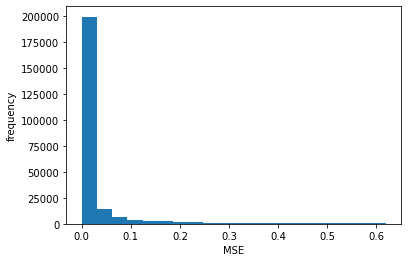

In [137]:
# MSE trn	MSE tst	MSE_tst_last	L1 trn	L1 tst	L1 tst last	max anchor seen

low, high = df_total_clean['MSE_tst_last'].quantile([0.1,0.9])
df_filtered = df_total_clean.query('{low}<MSE_tst_last<{high}'.format(low=low,high=high))
plt.hist(df_filtered['MSE_tst_last'],bins=20)
plt.xlabel('MSE')
plt.ylabel('frequency')
plt.show()


# Learning curve of a learning curve

In [147]:
num_datasets


TypeError: object of type 'AxesSubplot' has no len()

In [159]:
percentage = 0.25
percentage_buckets = [0.05, 0.1, 0.2, 0.4, 1]
percentage_buckets = np.array(percentage_buckets)
bucket = np.argwhere(percentage < percentage_buckets)[0][0]
bucket

3

In [171]:
df_total_clean = df_total_clean.query('openmlid == 11')

percentage_buckets = [0.05, 0.1, 0.2, 0.4, 1]
percentage_buckets = np.array(percentage_buckets)

buckets = []

for i in range(0,len(selected)):
    row = selected.iloc[i,:]
    percentage = row.percentage
    bucket = np.argwhere(percentage < percentage_buckets)[0][0]
    buckets.append(bucket)

df_total_clean.insert(0,'quartile',buckets)


<AxesSubplot:>

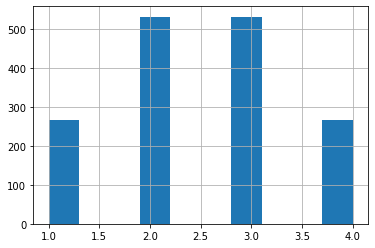

In [293]:
df_total_clean['quartile'].hist()

In [165]:
type(row)

pandas.core.series.Series

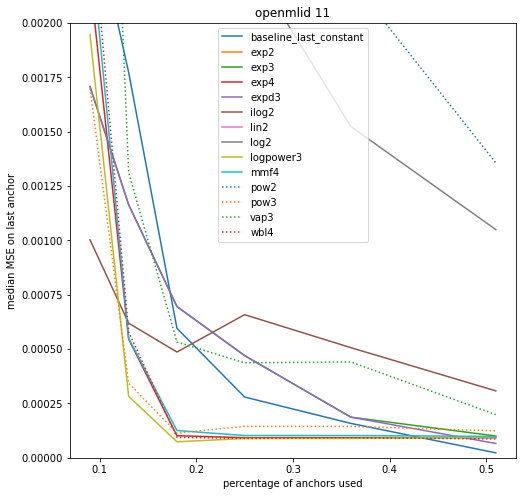

In [149]:
selected = df_total_clean.query('openmlid == 11')

num_datasets = len(selected['openmlid'].unique())

fig, axs = plt.subplots(num_datasets,figsize = (8,8*num_datasets))

j = 0
for openmlid, df_dataset in selected.groupby("openmlid"):
    i = 0
    ls = '-'
    for curve_model, df_curve_model in df_dataset.groupby("curve_model"):

        Y = df_curve_model.groupby('percentage')['MSE_tst_last'].median()
        Y_sigma = df_curve_model.groupby('percentage')['MSE_tst_last'].std()
        X = df_curve_model.groupby('percentage')['MSE_tst_last'].median().index
        if i > 9:
            ls = ':'
        if num_datasets > 1:
            my_ax = axs[j]
        else:
            my_ax = axs
        my_ax.plot(X,Y,ls,label=curve_model)
        
        i += 1
    my_ax.set_ylim([0,0.002])
    my_ax.set_title('openmlid %d' % openmlid)
    j += 1
    
plt.xlabel('percentage of anchors used')
plt.ylabel('median MSE on last anchor')
plt.legend()
plt.show()


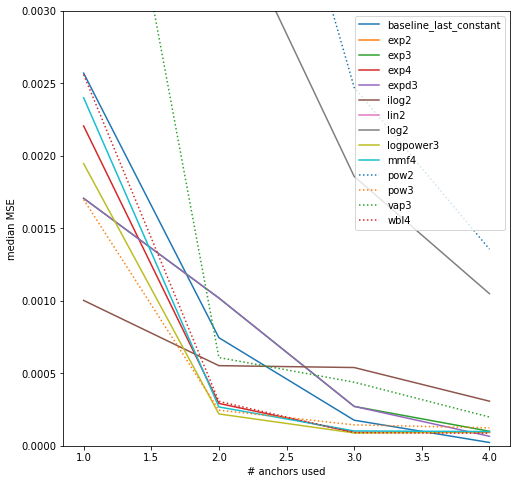

In [186]:
selected = df_total_clean

plt.figure(figsize=(8,8))

ls = '-'
i = 0
for curve_model, df_curve_model in selected.groupby("curve_model"):

    Y = df_curve_model.groupby('quartile')['MSE_tst_last'].median()
    Y_sigma = df_curve_model.groupby('quartile')['MSE_tst_last'].std()
    X = df_curve_model.groupby('quartile')['MSE_tst_last'].median().index

    if i > 9:
        ls = ':'
    i += 1
    plt.plot(X,Y,ls,label=curve_model)
    
plt.xlabel('# anchors used')
plt.ylabel('median MSE')
plt.legend()
plt.ylim([0,0.003])
plt.show()


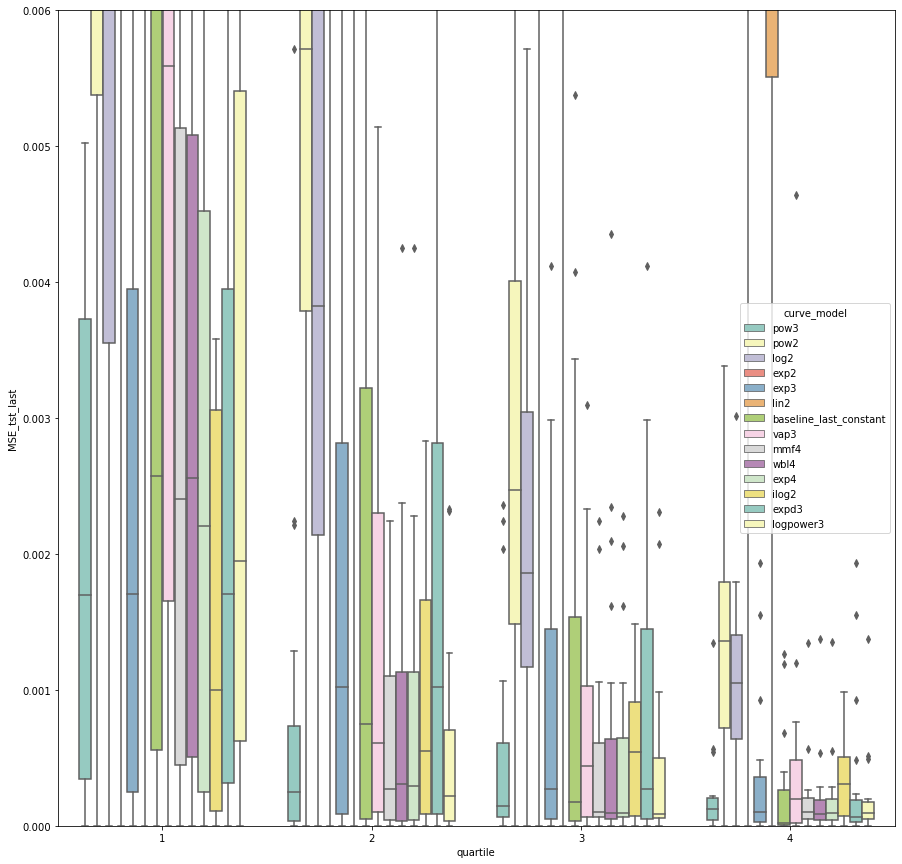

In [185]:
import seaborn as sns
plt.figure(figsize=(15,15))
sns.boxplot(x="quartile", y="MSE_tst_last", hue="curve_model", data=df_total_clean, palette="Set3") 
plt.ylim([0,0.006])
plt.show()

In [194]:
percentage_buckets_str = ['curve_model']
for perc in percentage_buckets:
    percentage_buckets_str.append(str(perc))
percentage_buckets_str = percentage_buckets_str[:-1]

In [192]:
row

['wbl4',
 0.002560764816000077,
 0.0003064454886400313,
 9.062516863998424e-05,
 8.67282438399857e-05]

In [274]:
rows = []
for curve_model, df_subgroup in df_total_clean.groupby(["curve_model"]):
    row = [curve_model]
    for quartile, df_subgroup2 in df_subgroup.groupby(['quartile']):
        row.append(df_subgroup2['MSE_tst_last'].median())
    rows.append(row)
    
my_res = pd.DataFrame(rows,columns=[percentage_buckets_str])



In [277]:
my_res

,curve_model,0.05,0.1,0.2,0.4
0,baseline_last_constant,0.002571,0.000746,0.000177,0.000023
1,exp2,2.106864,0.533818,0.064922,0.014405
2,exp3,0.001707,0.001019,0.000272,0.000100
3,exp4,0.002207,0.000292,0.000093,0.000092
4,expd3,0.001707,0.001019,0.000272,0.000066
5,ilog2,0.001003,0.000553,0.000540,0.000308
6,lin2,0.563899,0.237786,0.043001,0.012594
7,log2,0.006516,0.003825,0.001859,0.001050
8,logpower3,0.001947,0.000220,0.000089,0.000095
9,mmf4,0.002401,0.000268,0.000102,0.000098


In [308]:
my_res_ranks = my_res.copy()
for col in percentage_buckets_str:
    if col == 'curve_model':
        continue
    my_res_ranks[col] = my_res_ranks[col].rank(method='average')
my_res_ranks['0.05']

,0.05
0,9.0
1,14.0
2,3.5
3,6.0
4,3.5
5,1.0
6,13.0
7,11.0
8,5.0
9,7.0


In [310]:
print('\\begin{table}[]')
print('\\ttfamily')
print('\\begin{tabular}{lllll}')
for (i,text) in enumerate(percentage_buckets_str):
    if text == 'curve_model':
        text = 'curve model'
    if i == 0:
        print('%12s' % text,' ',end='')
    else:
        print('%8s' % text,' ',end='')
    if i < 4:
        print('&',end='')
print('\\\\')
first = True
for i in range(0,len(my_res)):
    row = my_res.iloc[i,:]
    for (j,num) in enumerate(row.values):
        if j == 0:
            if num == 'baseline_last_constant':
                num = 'last1'
            print('%12s' % num,' ',end='')
        else:
            rank = my_res_ranks.iloc[i,j]
            if rank >= 1 and rank <= 3.5: # [1,2,3]:
                print('\\cellcolor{YellowGreen}{%8.5f} '%num,end='')
            elif rank > 3.5 and rank <= 7.5: # in [4, 5, 6, 7]:
                print('\\cellcolor{Goldenrod}{%8.5f} '%num,end='')
            elif rank > 7.5 and rank <= 10.5: #rank in [8, 9, 10]:
                print('\\cellcolor{White}{%8.5f} '%num,end='')
            elif rank > 10.5 and rank <= 14: # rank in [12,13,14]:
                print('\\cellcolor{Gray}{%8.5f} '%num,end='')
            else:
                print(' ')
                print(rank)
                print(' ')
        if j < 4:
            print('&',end='')
    print('\\\\')
print('\\end{tabular}')
print('\\end{table}')

\begin{table}[]
\ttfamily
\begin{tabular}{lllll}
 curve model  &    0.05  &     0.1  &     0.2  &     0.4  \\
       last1  &\cellcolor{White}{ 0.00257} &\cellcolor{White}{ 0.00075} &\cellcolor{Goldenrod}{ 0.00018} &\cellcolor{YellowGreen}{ 0.00002} \\
        exp2  &\cellcolor{Gray}{ 2.10686} &\cellcolor{Gray}{ 0.53382} &\cellcolor{Gray}{ 0.06492} &\cellcolor{Gray}{ 0.01441} \\
        exp3  &\cellcolor{YellowGreen}{ 0.00171} &\cellcolor{White}{ 0.00102} &\cellcolor{Goldenrod}{ 0.00027} &\cellcolor{Goldenrod}{ 0.00010} \\
        exp4  &\cellcolor{Goldenrod}{ 0.00221} &\cellcolor{Goldenrod}{ 0.00029} &\cellcolor{YellowGreen}{ 0.00009} &\cellcolor{Goldenrod}{ 0.00009} \\
       expd3  &\cellcolor{YellowGreen}{ 0.00171} &\cellcolor{White}{ 0.00102} &\cellcolor{Goldenrod}{ 0.00027} &\cellcolor{YellowGreen}{ 0.00007} \\
       ilog2  &\cellcolor{YellowGreen}{ 0.00100} &\cellcolor{Goldenrod}{ 0.00055} &\cellcolor{White}{ 0.00054} &\cellcolor{White}{ 0.00031} \\
        lin2  &\cellcolor{Gr

In [140]:
a = df_total_clean.groupby('curve_model')['MSE_tst_last'].median()
a.sort_values()

curve_model
mmf4                      0.000463
exp4                      0.000641
pow3                      0.000644
wbl4                      0.000648
logpower3                 0.000789
baseline_last_constant    0.000808
ilog2                     0.001005
expd3                     0.001393
exp3                      0.001607
vap3                      0.002472
log2                      0.005279
pow2                      0.008287
lin2                      0.830964
exp2                      1.910344
Name: MSE_tst_last, dtype: float64

In [ ]:
df_total_clean['learner']

In [141]:
df_total_clean.groupby('learner')['MSE_tst_last'].median().sort_values()

learner
sklearn.naive_bayes.BernoulliNB                                0.000481
sklearn.naive_bayes.MultinomialNB                              0.001034
sklearn.linear_model.PassiveAggressiveClassifier               0.001165
sklearn.linear_model.LogisticRegression                        0.001505
sklearn.linear_model.RidgeClassifier                           0.001832
SVC_linear                                                     0.001901
sklearn.linear_model.Perceptron                                0.002013
sklearn.neighbors.KNeighborsClassifier                         0.002167
sklearn.ensemble.ExtraTreesClassifier                          0.002269
SVC_poly                                                       0.002276
sklearn.ensemble.RandomForestClassifier                        0.002468
sklearn.linear_model.SGDClassifier                             0.002546
sklearn.tree.ExtraTreeClassifier                               0.003008
sklearn.tree.DecisionTreeClassifier                     

In [142]:
df_total_clean.describe()

,openmlid,max_anchor_seen,MSE_trn,MSE_tst,MSE_tst_last,L1_trn,L1_tst,L1_tst_last,max anchor seen,percentage,n
count,300941.000000,300941.000000,3.009410e+05,3.009410e+05,3.009410e+05,3.009410e+05,3.009410e+05,3.009410e+05,300941.000000,300941.000000,300941.000000
mean,479.126450,4340.345058,2.183232e-03,3.582782e+298,7.059158e+299,2.183232e-03,3.582782e+298,7.059158e+299,4411.454162,0.189146,10.548274
std,326.871231,26338.706457,1.860452e-02,inf,inf,1.860452e-02,inf,inf,26800.220741,0.216448,5.080746
min,3.000000,45.000000,2.311116e-33,0.000000e+00,0.000000e+00,2.311116e-33,0.000000e+00,0.000000e+00,45.000000,0.000000,4.000000
25%,180.000000,128.000000,1.884452e-05,1.761525e-04,2.003923e-04,1.884452e-05,1.761525e-04,2.003923e-04,128.000000,0.030000,7.000000
50%,399.000000,362.000000,7.439272e-05,1.360323e-03,2.273001e-03,7.439272e-05,1.360323e-03,2.273001e-03,362.000000,0.100000,10.000000
75%,807.000000,1024.000000,3.732162e-04,1.223753e-02,2.583863e-02,3.732162e-04,1.223753e-02,2.583863e-02,1024.000000,0.300000,13.000000
max,910.000000,524288.000000,7.623948e-01,4.578164e+303,8.240695e+304,7.623948e-01,4.578164e+303,8.240695e+304,524288.000000,0.990000,31.000000


# Look at parameter values

In [ ]:
df_total_clean = df_total_clean.rename(columns={'MSE trn': 'MSE_trn'})

In [ ]:
num_curve_models = df_total_clean['curve_model'].unique()
num_curve_models

In [ ]:
plt.figure()
j = 0
df_selected = df_total_clean.query('curve_model == "lin2"')
for curve_model, df_dataset in df_selected.groupby("curve_model"):
    beta_list = []
    for i in range(0,len(df_dataset)):
        row = df_dataset.iloc[i,:]
        beta = row.beta
        beta_list.append(beta)

    a = np.array(beta_list)
    plt.boxplot(a)
    plt.ylim([-0.25,0.25])


In [ ]:
df_total_clean

#df_selected = df_total_clean.query('curve_model == "lin2" and MSE_trn < 0.05')
#df_selected = df_total_clean.query('curve_model == "lin2"')
df_selected = df_total_clean

fig, axs = plt.subplots(len(num_curve_models),figsize=(15,15))
j = 0
for curve_model, df_dataset in df_selected.groupby("curve_model"):
    beta_list = []
    for i in range(0,len(df_dataset)):
        row = df_dataset.iloc[i,:]
        beta = row.beta
        beta_list.append(beta)

    a = np.array(beta_list)
    axs[j].boxplot(a)
    axs[j].set_ylim([-2,2])
    axs[j].set_title(curve_model)
    j = j+1

In [ ]:
np.array(beta_list).shape

In [ ]:
total_list = np.empty((1,1))
total_list.shape

In [ ]:
df_total_clean

#df_selected = df_total_clean.query('curve_model == "lin2" and MSE_trn < 0.05')
#df_selected = df_total_clean.query('curve_model == "lin2"')
df_selected = df_total_clean

first = True
for curve_model, df_dataset in df_selected.groupby("curve_model"):
    beta_list = []
    for i in range(0,len(df_dataset)):
        row = df_dataset.iloc[i,:]
        beta = row.beta
        beta_list.append(beta)
    beta_list = np.array(beta_list)
    if first:
        total_list = np.reshape(beta_list,(-1,1))
        first = False
    else:
        total_list = np.hstack((total_list,beta_list))
    

In [ ]:
pd.DataFrame(total_list).describe()

In [ ]:
total_list.shape

# Visualize fits

In [ ]:
df_total_clean

In [ ]:
df

In [ ]:
learners = df['learner'].unique()
learners

In [ ]:

learner = learners[18]
openmlid = 11
n = 9
df_selected = df_total_clean.query('openmlid==@openmlid and learner==@learner and n==@n')
df_selected

[X, Y] = get_info_mean_curve(df_anchors_and_scores, openmlid, learner)

plt.figure(figsize=(8,8))
plt.plot(X,Y,'*')
for i in range(0,len(df_selected)):
    row = df_selected.iloc[i,:]
    Y_hat = row.prediction
    plt.plot(X,Y_hat,'-',label=row.curve_model)
    
plt.title('%s dataset %d' % (learner, openmlid))
plt.ylim([np.min(Y),np.max(Y)])
plt.xlabel('train samples')
plt.ylabel('MSE')
plt.legend()
plt.show()


In [ ]:
learner = 'sklearn.linear_model.Perceptron'

In [ ]:
#    def exp3(beta):
#        a, b, c = tuple(beta.astype(float))
#        pl = lambda x: a * np.exp(-b*x) + c

In [ ]:
def get_pow4(sizes, scores):
    def pow4(beta):
        a, b, c, d = tuple(beta.astype(float))
        pl = lambda x: c - (-a*x + b)**d
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((pl(size) - scores[i])**2)
        return np.array(penalty)

    a, b, c, d = tuple(sp.optimize.least_squares(pow4, np.array([0.0001,0.2,1,1]), method="lm").x)
    return (a, b, c, d), lambda x: c - (-a*x + b)**d

In [ ]:
[beta,func] = get_exp2_good_init(X,Y)

In [ ]:
Y_hat

In [ ]:
learner = learners[0]
openmlid = 11

[X, Y] = get_info_mean_curve(df_anchors_and_scores, openmlid, learner)

beta, pow4 = get_pow4(X,Y)

Y_hat = pow4(X)

plt.figure()
plt.plot(X,Y,'*')
plt.plot(X, Y_hat, '-o')


In [ ]:
beta

In [ ]:
beta

# Learner influence

(0.0, 0.1)

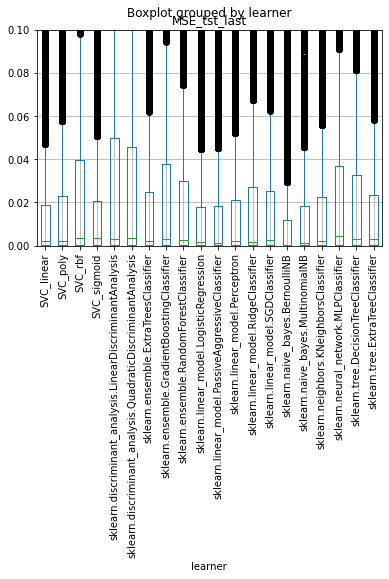

In [143]:
df_total_clean.boxplot(column='MSE_tst_last',by='learner',rot=90)
plt.ylim([0,0.1])

# Curve model influence

(0.0, 0.1)

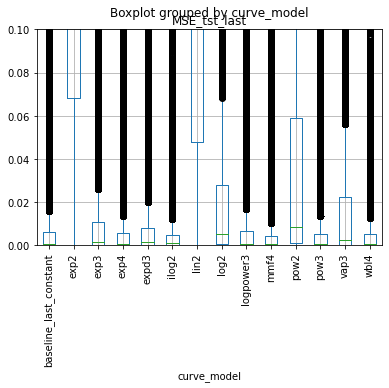

In [144]:
df_total_clean.boxplot(column='MSE_tst_last',by='curve_model',rot=90)
plt.ylim([0,0.1])